In [1]:
import pickle

import numpy as np

import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats as stats
import arviz as az

import torch
import torch.nn as nn
import torch.optim as optim

import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample


from models import deconvolution


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = 'cpu'

torch.set_default_device(device)


/home/akseli/dippa/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Inverse problem 

In [2]:
# Parameters
T = 0.05
N = 100
domain = [0, 1]
sigma_noise = 0.05
mu_u = -1
sigma_2_u = 0.05**2

n = 2*N
t = np.linspace(domain[0],domain[1], N)
t = np.round(t, 3)
d_k = 40

h = domain[1] / N

params = [0, 2.0, 0.2, 1.0, 0]

def problem_system(grid: np.array, params)-> np.array:

    output = np.zeros(grid.shape)
    for idx, point in enumerate(grid):
        if point <= 0.1:
            output[idx] = params[0]
        elif point <= 0.2:
            output[idx] = params[1]
        elif point <= 0.4:
            output[idx] = params[2]
        elif point <= 0.75:
            #output[idx] = params[3]
            output[idx] = 0.3*np.sin(2*np.pi*point*2)+params[3]
        else:
            output[idx] = point*params[4]
    
    return output



## Convolution matrix

In [3]:
model = deconvolution(int(np.round(n/2)), int(n/16), 'reflect')
A = model.linear_operator(n)
A = A[1::2, :]

#A[0,0] = 0
#A[-1, -1] = 0

## Data Generation

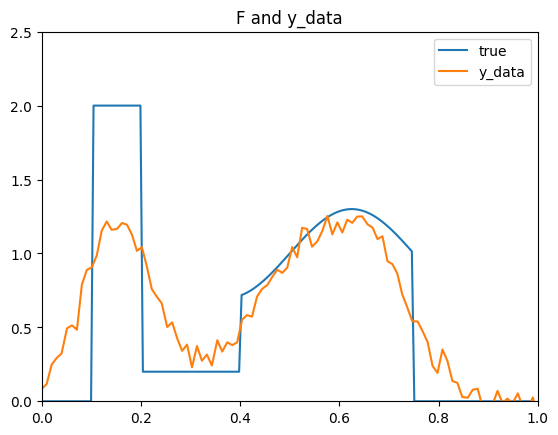

In [4]:
# Generate grid points
x = np.linspace(0, domain[1] - h, n)

# Construct the function f
f = problem_system(x, params)
#f = np.sin(10*x-0.2)
f = A@f
ind = f > 0
f *= ind

# Create y_data with noise
y_data = f + np.random.normal(0, sigma_noise, f.shape)

f = problem_system(x, params)

# Plot f and w
plt.figure()
plt.plot(x, f, label='true')
plt.plot(t, y_data, label='y_data')
plt.axis([domain[0], domain[1], 0, 2.5])
plt.title('F and y_data')
plt.legend()
plt.show()

Old targets

## Pyro BNN

In [5]:
class BNN(PyroModule):

    def __init__(self, h1, h2):
        super().__init__()
        self.fc1 = PyroModule[nn.Linear](h1, h2)
        self.fc1.weight = PyroSample(dist.Normal(0.,
                                                torch.tensor(0.5)).expand([h2, h1]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0.,
                                               torch.tensor(0.5)).expand([h2]).to_event(1))
        
        #self.fc1 = nn.Linear(h1, h2)

        self.fc2 = PyroModule[nn.Linear](h1, h2)
        self.fc2.weight = PyroSample(dist.Cauchy(0.,
                                                torch.tensor(0.5)).expand([h2, h2]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0.,
                                               torch.tensor(0.05)).expand([h2]).to_event(1))

        self.fc3 = PyroModule[nn.Linear](h1, h2)
        self.fc3.weight = PyroSample(dist.Normal(0.,
                                                torch.tensor(0.5)).expand([h2, h2]).to_event(2))
        self.fc3.bias = PyroSample(dist.Normal(0.,
                                               torch.tensor(0.05)).expand([h2]).to_event(1))

        self.relu = nn.ReLU()

    def forward(self, x, y=None):
        
        x = x#.reshape(-1, 1)

        mu = self.relu(self.fc1(x))#.squeeze()
        mu = self.relu(self.fc2(mu))
        mu = self.relu(self.fc3(mu))
        #mu = x
        sigma = pyro.sample("sigma", dist.Uniform(0.,
                                                torch.tensor(0.05)))
    
        with pyro.plate("data", 200):
            obs = pyro.sample("obs", dist.Normal(mu, sigma), obs=y)
        
        return mu

In [6]:
# Convert data to PyTorch tensors
x_train = torch.from_numpy(t).float().cuda()
y_train = torch.from_numpy(y_data).float().cuda()


## Load BNN model for signals, Prior

In [7]:
bnn_model = BNN(h1=N, h2=n)

In [8]:
predictive = torch.load('../svi_model.pt')

#### Generate prior for the y

In [9]:
prior_bnn = predictive(y_train)

In [10]:
prior_bnn = prior_bnn['obs']
prior_bnn.shape

torch.Size([5000, 200])

#### Plotting the prior

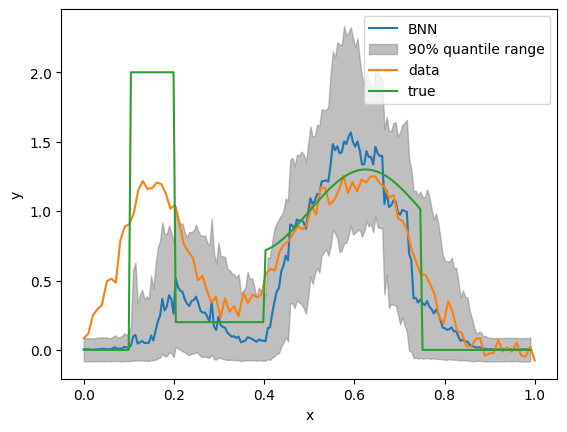

In [11]:
# Calculate mean and quantiles
mean_preds = torch.mean(prior_bnn, axis=0).cpu()
lower_quantile = torch.quantile(prior_bnn, 0.05, axis=0).cpu()
upper_quantile = torch.quantile(prior_bnn, 0.95, axis=0).cpu()

# Plot the mean prediction
plt.plot(x, mean_preds, label='BNN')

# Plot the quantile range as a shaded area
plt.fill_between(x, lower_quantile, upper_quantile, color='gray', alpha=0.5, label='90% quantile range')

# Plot the true data and the true function
plt.plot(t, y_data, label='data')
plt.plot(x, f, label='true')

# Add labels and legend
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# Show the plot
plt.show()


## Sampling with NUTS

It is not working yet, I can't seem to sample the prior correctly. Have asked Pyro forum for help. 

The code works with just using a Gaussian prior. 

In [12]:
A.shape

(100, 200)

In [131]:
import pyro.infer.autoguide
import pyro
import pyro.distributions as dist
import pyro.infer

from torch.distributions import constraints
from pyro import poutine
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate, infer_discrete
from pyro.infer.autoguide import AutoNormal
from pyro.ops.indexing import Vindex

from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal
from tqdm.auto import trange
from pyro.optim import Adam


predictive = pyro.poutine.block(predictive, hide_all=True)
A = torch.tensor(A, dtype=torch.float32).cuda()    # shape [100, 200]
y_data = torch.tensor(y_data, dtype=torch.float32) # shape [100, 1]
f_gpu = torch.tensor(f, dtype=torch.float32) # shape [100, 1]


@config_enumerate
def inverse_model(A, y_data):
    
    n = A.size(1)  # Number of features
    prior_samples = pyro.param('prior', prior_bnn.cuda()) # shape [5000, 200]
    
    sigma = pyro.sample("sigma", dist.Uniform(0., 0.05)).to(A.device)

    x = []
    omega = torch.zeros([n, 1])
    for ii in pyro.plate("plate", n):  # <--- valid sequential plate
        x.append(pyro.sample(f"x_{ii}", dist.Categorical(torch.ones(5000))))
        omega[ii] = prior_samples[x[ii], ii]
    assert len(x) == n
    assert omega.shape == (n, 1)
    
    mu = torch.matmul(A, omega)
        
    with pyro.plate("data", y_data.shape[0]):
        #print(f'\nmu.shape: {mu.shape},\nsigma.shape: {sigma.shape},\ny_data.shape: {y_data.shape}\n')
        pyro.sample("obs", dist.Normal(mu.squeeze(-1), sigma), obs=y_data)
    return omega


def guide(A, y_data):
    # Define the variational parameters for x
    q_x_probs = pyro.param('q_x_probs', torch.ones(5000) / 5000,
                           constraint=constraints.simplex)

    x = []
    omega = torch.zeros([200, 1])
    for ii in pyro.plate("plate", 200):  # <--- valid sequential plate
        x.append(pyro.sample(f"x_{ii}", dist.Categorical(q_x_probs)))
    pyro.sample("sigma", dist.Uniform(0., 0.05))


    return {"omega": omega}


adam_params = {"lr": 0.0005, "betas": (0.95, 0.999)}
optimizer = Adam(adam_params)
svi = pyro.infer.SVI(inverse_model, guide, optimizer, loss=TraceEnum_ELBO())

num_iterations = 50
progress_bar = trange(num_iterations)

for j in progress_bar:

    loss = svi.step(A, y_data)
    progress_bar.set_description("[iteration %04d] loss: %.4f" % (j + 1, loss))


  0%|          | 0/50 [00:00<?, ?it/s]/home/akseli/dippa/.venv/lib/python3.10/site-packages/pyro/infer/traceenum_elbo.py:355: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.
  warnings.warn(
[iteration 0050] loss: 3132.7434: 100%|██████████| 50/50 [01:22<00:00,  1.64s/it]    


In [ ]:
#pyro.render_model(inverse_model,model_args=(A, y_data))

In [132]:
predictive = pyro.infer.Predictive(inverse_model, guide=guide, num_samples=50,
                        return_sites=["_RETURN"])

preds_gpu = predictive(A, y_data)

In [133]:
omega = preds_gpu["_RETURN"].squeeze(0)

In [134]:
preds_inverse = preds_gpu['obs']

KeyError: 'obs'

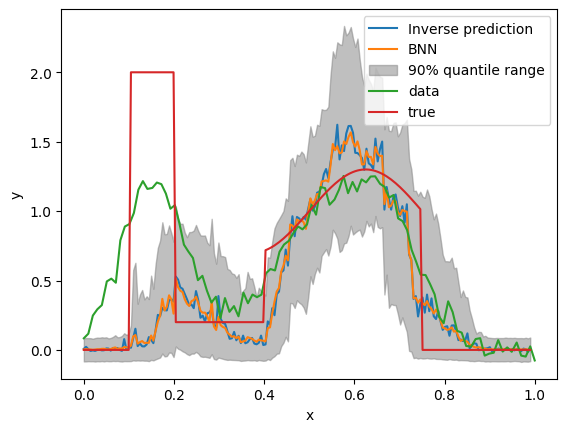

In [137]:
#plt.plot(t, torch.mean(preds_inverse.cpu(), axis=0), label='Inverse prediction')
plt.plot(x, torch.mean(omega.detach().cpu(), axis=0), label='Inverse prediction')
# Plot the mean prediction
plt.plot(x, mean_preds, label='BNN')

# Plot the quantile range as a shaded area
plt.fill_between(x, lower_quantile, upper_quantile, color='gray', alpha=0.5, label='90% quantile range')

# Plot the true data and the true function
plt.plot(t, y_data.cpu(), label='data')
plt.plot(x, f, label='true')

# Add labels and legend
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# Show the plot
plt.show()